In [1]:
! pip install split-folders

In [2]:
!git clone https://github.com/etahamad/grower-dataset --depth=1

Cloning into 'grower-dataset'...
remote: Enumerating objects: 163223, done.
remote: Counting objects: 100% (163223/163223), done.
remote: Compressing objects: 100% (163090/163090), done.
remote: Total 163223 (delta 130), reused 163219 (delta 130), pack-reused 0
Receiving objects: 100% (163223/163223), 2.09 GiB | 14.76 MiB/s, done.
Resolving deltas: 100% (130/130), done.
Updating files: 100% (182410/182410), done.


In [3]:
import splitfolders

splitfolders.ratio(
  "/kaggle/working/grower-dataset/datasets/raw/segmented", 
  output="/kaggle/working/finalDataset",
  seed=7,
  ratio=(0.90, 0.050, 0.050)
)

Copying files: 54306 files [00:11, 4569.09 files/s]


In [4]:
!rm -rf /kaggle/working/grower-dataset

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator , load_img , img_to_array
from keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPool2D, Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras import Model
from keras.metrics import Precision, Recall

import numpy as np
from skimage import transform

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
import seaborn as sns
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10268515200285018505
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 15774515200
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13368091034148105291
physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
]


2022-12-25 13:52:47.917719: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-25 13:52:47.979183: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 13:52:47.980220: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 13:52:47.980901: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA 

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=10,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    width_shift_range=0.1
)
valid_datagen = ImageDataGenerator(rescale=1/255)
test_datagen = ImageDataGenerator(rescale=1/255)

train_dataset = train_datagen.flow_from_directory(
  '/kaggle/working/finalDataset/train',
  target_size=(256, 256),
  class_mode='categorical', 
  batch_size=100,
)

test_dataset = test_datagen.flow_from_directory(
  '/kaggle/working/finalDataset/test',
  target_size=(256, 256),
  class_mode='categorical',
  batch_size=100,
  shuffle=False
)

valid_dataset = valid_datagen.flow_from_directory(
  '/kaggle/working/finalDataset/val',
  target_size=(256, 256),
  class_mode='categorical',
  batch_size=100,
)


Found 48858 images belonging to 38 classes.
Found 2750 images belonging to 38 classes.
Found 2698 images belonging to 38 classes.


In [8]:
import keras
METRICS = [
    'accuracy',
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall')
]

def evaluate(actual, predictions):
  pre = []
  for i in predictions:
    pre.append(np.argmax(i))

  accuracy = (pre == actual).sum() / actual.shape[0]
  print(f'Accuracy: {accuracy}')

  precision, recall, f1_score, _ = precision_recall_fscore_support(actual, pre, average='macro')
  print(f'Precision: {precision}')
  print(f'Recall: {recall}')
  print(f'F1_score: {f1_score}')

  fig, ax = plt.subplots(figsize=(10,10))
  conf_mat = confusion_matrix(actual, pre)
  sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="YlGnBu", xticklabels=diseases_labels, yticklabels=diseases_labels).set_title('Confusion Matrix Heat map')
  plt.show()



diseases_labels = []

for key, value in train_dataset.class_indices.items():
   diseases_labels.append(key)

2022-12-25 13:52:53.993192: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 13:52:53.994343: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 13:52:53.995303: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 13:52:53.996756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-25 13:52:53.997430: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

In [9]:
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=train_dataset.image_shape))
model.add(MaxPool2D(2))

model.add(Conv2D(32, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(MaxPool2D(2))


model.add(Flatten())

model.add(Dense(512, activation='relu'))


model.add(Dense(38, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 254, 254, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 125, 125, 32)      9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 62, 62, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        3

In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=METRICS)

In [11]:
Info = model.fit(
  train_dataset,
  validation_data=valid_dataset,
  epochs=24,
  workers=2
)

2022-12-25 13:52:56.342626: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/24


2022-12-25 13:53:01.802185: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


489/489 [==============================] - 637s 1s/step - loss: 2.2470 - accuracy: 0.3777 - precision: 0.7034 - recall: 0.1965 - val_loss: 0.9847 - val_accuracy: 0.6990 - val_precision: 0.8476 - val_recall: 0.5482
Epoch 2/24
489/489 [==============================] - 633s 1s/step - loss: 1.0339 - accuracy: 0.6860 - precision: 0.8114 - recall: 0.5775 - val_loss: 0.7556 - val_accuracy: 0.7569 - val_precision: 0.8429 - val_recall: 0.6861
Epoch 3/24
489/489 [==============================] - 629s 1s/step - loss: 0.6387 - accuracy: 0.7995 - precision: 0.8640 - recall: 0.7442 - val_loss: 0.3275 - val_accuracy: 0.8921 - val_precision: 0.9197 - val_recall: 0.8621
Epoch 4/24
489/489 [==============================] - 638s 1s/step - loss: 0.4598 - accuracy: 0.8535 - precision: 0.8936 - recall: 0.8197 - val_loss: 0.2700 - val_accuracy: 0.9118 - val_precision: 0.9328 - val_recall: 0.8951
Epoch 5/24
489/489 [==============================] - 629s 1s/step - loss: 0.3629 - accuracy: 0.8835 - precisio

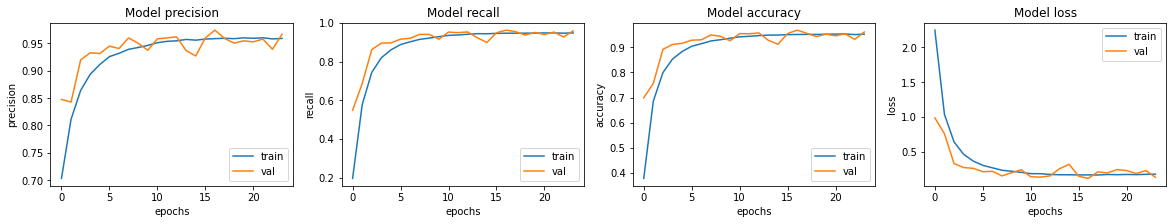

In [12]:
fig, ax = plt.subplots(1, 4, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['precision', 'recall', 'accuracy', 'loss']):
    ax[i].plot(Info.history[met])
    ax[i].plot(Info.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [13]:
predictions = model.predict(test_dataset)

In [14]:
train_dataset.class_indices

{'Apple___Apple_scab': 0,
 'Apple___Black_rot': 1,
 'Apple___Cedar_apple_rust': 2,
 'Apple___healthy': 3,
 'Blueberry___healthy': 4,
 'Cherry_(including_sour)___Powdery_mildew': 5,
 'Cherry_(including_sour)___healthy': 6,
 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot': 7,
 'Corn_(maize)___Common_rust_': 8,
 'Corn_(maize)___Northern_Leaf_Blight': 9,
 'Corn_(maize)___healthy': 10,
 'Grape___Black_rot': 11,
 'Grape___Esca_(Black_Measles)': 12,
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 13,
 'Grape___healthy': 14,
 'Orange___Haunglongbing_(Citrus_greening)': 15,
 'Peach___Bacterial_spot': 16,
 'Peach___healthy': 17,
 'Pepper,_bell___Bacterial_spot': 18,
 'Pepper,_bell___healthy': 19,
 'Potato___Early_blight': 20,
 'Potato___Late_blight': 21,
 'Potato___healthy': 22,
 'Raspberry___healthy': 23,
 'Soybean___healthy': 24,
 'Squash___Powdery_mildew': 25,
 'Strawberry___Leaf_scorch': 26,
 'Strawberry___healthy': 27,
 'Tomato___Bacterial_spot': 28,
 'Tomato___Early_blight': 29,
 'Toma

Accuracy: 0.9661818181818181
Precision: 0.9572633524917151
Recall: 0.9591271165279801
F1_score: 0.9568795613425757


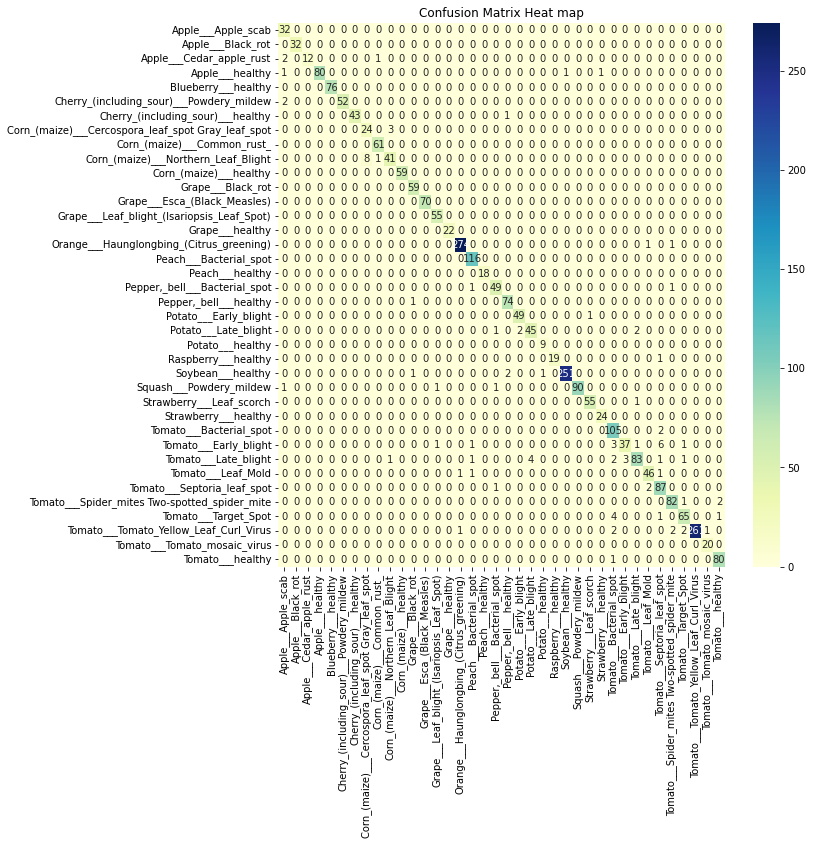

In [15]:
evaluate(test_dataset.classes,predictions)

In [16]:
model.evaluate(test_dataset)

28/28 [==============================] - 8s 298ms/step - loss: 0.1120 - accuracy: 0.9662 - precision: 0.9710 - recall: 0.9622


[0.11195230484008789,
 0.9661818146705627,
 0.9710091948509216,
 0.962181806564331]

In [17]:
model.save("grower_model_v2.h5")